### INIT

In [1]:
# env: py3

import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# sns style without grid
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_palette("Set2")

In [2]:
# function to extract trusted hits and good hits from CANT-HYD annotation
def extract_canthyd_hits(fin_canthyd_rst, df_canthyd_cutoffs):
    df_hmmer = pd.read_csv(fin_canthyd_rst, sep='\t', header=0)
    df = pd.merge(df_canthyd_cutoffs, df_hmmer, on='dbid', how='inner')
    df['trusted_hit'] = df['bitscore'] >= df['Trusted_Cutoff']
    df['good_hit'] = df['bitscore'] >= df['Noise_Cutoff']
    df_good = df[df['good_hit'] == True]
    df_trusted = df[df['trusted_hit'] == True]
    df_all = df
    return df_all.copy(), df_trusted.copy(), df_good.copy()

### IMPORTS

In [3]:
fin_canthyd_cutoffs = "/Users/allen/data/db/canthyd/cutoffs.tsv"
df_canthyd_cutoffs = pd.read_csv(fin_canthyd_cutoffs, sep='\t', header=0)

dpath_canthyd = "/Users/allen/github/rujinlong/phydgene/hpc/02_canthyd"
d_fins = {
    "IMGVR": "imgvr_canthyd.tsv.gz",
    "NCBIvirus": "ncbivirus_canthyd.tsv.gz",
    "PHROG_cluster": "phrog_cluster_canthyd.tsv.gz",
    "PHROG_singletons": "phrog_singletons_canthyd.tsv.gz",
    "Virome_virus": "virome_canthyd.tsv.gz",
    "Virome_all": "plass_cluster_canthyd.tsv.gz",
    "Isolates": "phagebac_canthyd.tsv.gz"
}

d_fins = {x: os.path.join(dpath_canthyd, y) for x, y in d_fins.items()}
d_dfs = {}
for k, v in d_fins.items():
    df_all, df_trusted, df_good = extract_canthyd_hits(v, df_canthyd_cutoffs)
    df_all["source"] = k
    df_trusted["source"] = k
    df_good["source"] = k
    d_dfs[k] = {"all": df_all, "trusted": df_trusted, "good": df_good}

# concat all dataframes
df_all = pd.concat([d_dfs[x]["all"] for x in d_dfs.keys()], ignore_index=True)

#### Stat

In [4]:
# Check which data source has trusted or good hits
for source in d_dfs.keys():
    for level in ["trusted", "good"]:
        df = d_dfs[source][level]
        if df.shape[0] > 0:
            print(source, level, df.shape[0])

IMGVR trusted 17
IMGVR good 17
Isolates trusted 58
Isolates good 86


#### Figure 1

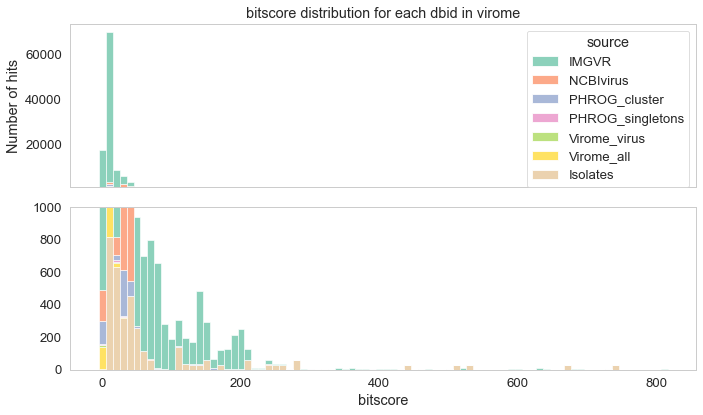

In [6]:
# Plot stacked histogram of bitscores using seaborn, bins=100
fig, (ax_top, ax_bottom) = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(10, 6))
sns.histplot(data=df_all, ax=ax_top, binwidth=10, fill=True, legend=True, multiple="stack", hue="source", x="bitscore")
sns.histplot(data=df_all, ax=ax_bottom, binwidth=10, fill=True, legend=False, multiple="stack", hue="source", x="bitscore")

ax_top.set_ylim(bottom=1000)
ax_bottom.set_ylim(0, 1000)

ax_top.set_title('bitscore distribution for each dbid in virome')
ax_top.set_ylabel("Number of hits")
ax_bottom.set_ylabel("")
ax_bottom.set_xlabel("bitscore")
plt.tight_layout()
plt.show()

#### Isolate phage contigs

In [7]:
# extract query_id from df_phagebac and convert to list
query_ids = set(d_dfs["Isolates"]["good"]['query_id'].tolist())

# contig_id is the part of query_id before the last underscore
contig_ids = [x.rsplit('_', 1)[0] for x in query_ids]

# convert contig_ids to dataframe and save to file
df_contig_ids = pd.DataFrame(contig_ids, columns=['contig_id'])

df_contig_ids

,contig_id
0,D45s15_6
1,D45s02_21
2,D45s14_17
3,DMPs08_17
4,MADJMMAF
...,...
81,DMPs03_4
82,DMPs08_14
83,D45s01_6
84,D45s11_25


In [10]:
tbl = d_dfs["IMGVR"]["trusted"]

# write tbl to file
tbl.to_csv("imgvr_good_hits.tsv", sep='\t', index=False)

In [12]:
tbl.to_excel("imgvr_trusted_hits.xlsx", index=False)